# Hidden Markov Model with Microstructure and Liquidity Variables

**Objective:** Construct a three-state HMM combining macro stress indicators with credit market microstructure and flow dynamics to identify regime-dependent mean reversion opportunities.

**Hypothesis:** Credit spread regimes are driven not only by macro stress but also by market microstructure conditions (order flow, liquidity pressure, spread dynamics). A parsimonious HMM incorporating both dimensions can identify:
- **Orderly/Informational regimes:** Low volatility, normal flow, weak mean reversion
- **Liquidity-driven/Tradable regimes:** Moderate flow pressure, mean reversion opportunities
- **Disorderly/Crisis regimes:** Extreme flow pressure, forced selling, rapid mean reversion

---

## 1. Model Specification

### 1.1 HMM Structure

**States:** $z_t \in \{0, 1, 2\}$ (three latent regimes)

**Transition dynamics:** $P(z_t = j | z_{t-1} = i) = A_{ij}$

**Emission distribution:** $X_t | z_t = k \sim \mathcal{N}(\mu_k, \Sigma_k)$ with diagonal $\Sigma_k$

**Estimation:** Baum-Welch EM algorithm

### 1.2 Input Feature Vector

At each time $t$, the HMM observes:

$$X_t = \begin{bmatrix} \text{VIX}_t \\ |\Delta S_t| \\ \text{RealizedVol}_t^{(10d)} \\ \Delta^2 S_t \\ \log(\text{Volume}_{\text{LQD},t}) \end{bmatrix}$$

where:

1. **VIX:** Equity market stress (macro indicator)
2. **$|\Delta S_t|$:** Absolute daily spread change (speed of movement)
3. **RealizedVol$_t^{(10d)}$:** 10-day rolling std of $\Delta S_t$ (microstructure volatility)
4. **$\Delta^2 S_t$:** Spread acceleration $= \Delta S_t - \Delta S_{t-1}$ (flow pressure proxy)
5. **$\log(\text{Volume}_{\text{LQD},t})$:** LQD ETF trading volume (liquidity proxy)

All variables are standardized (z-scored) prior to estimation.

### 1.3 Signal Definition (Separate from HMM)

The credit spread signal remains:
$$S_t = \text{BAMLC0A0CM}_t$$

The spread level $S_t$ is **not** included in the HMM feature set. It is used exclusively for mean reversion testing.

---

## 2. Data Loading and Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.regression.quantile_regression import QuantReg
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

Path('../results/hmm_microstructure').mkdir(parents=True, exist_ok=True)
Path('../results/figures').mkdir(parents=True, exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10

np.random.seed(42)

In [2]:
# Load macro and credit spread data
df = pd.read_csv('../data/processed/full_processed_data_hmm.csv', index_col=0, parse_dates=True)
df = df.loc['2015-01-01':'2024-12-31'].copy()

# Load LQD ETF data
lqd = pd.read_csv('../data/processed/lqd_etf_data.csv', index_col=0, parse_dates=True)

# Merge datasets
df = df.join(lqd, how='inner')

print(f"Sample period: {df.index.min().date()} to {df.index.max().date()}")
print(f"Observations: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")

Sample period: 2015-01-29 to 2024-12-31
Observations: 2498

Columns: ['spread', 'vix', 'anfci', 'dgs10', 'dgs2', 'dgs3mo', 'dtwexbgs', 'regime', 'hmm_realized_vol', 'hmm_abs_change', 'hmm_stress_interaction', 'hmm_term_spread', 'hmm_dollar_strength', 'lqd_close', 'lqd_volume', 'lqd_return']


## 3. Microstructure Feature Engineering

We construct variables that capture credit spread microstructure dynamics and market flow pressure.

In [3]:
# Spread microstructure variables
df['spread_change'] = df['spread'].diff()
df['spread_change_abs'] = df['spread_change'].abs()
df['spread_accel'] = df['spread_change'].diff()  # Second difference (acceleration)
df['spread_rvol_10d'] = df['spread_change'].rolling(window=10).std()

# LQD ETF flow/liquidity variables
df['lqd_log_volume'] = np.log(df['lqd_volume'] + 1)  # Log volume (add 1 to avoid log(0))
df['lqd_abs_return'] = df['lqd_return'].abs()

# Drop NaN rows from rolling computations
df = df.dropna()

print(f"\nAfter feature engineering: {len(df)} observations")
print(f"\nMicrostructure features summary:")
micro_cols = ['spread_change_abs', 'spread_accel', 'spread_rvol_10d', 'lqd_log_volume', 'lqd_abs_return']
print(df[micro_cols].describe())


After feature engineering: 2488 observations

Microstructure features summary:
       spread_change_abs  spread_accel  spread_rvol_10d  lqd_log_volume  \
count        2488.000000   2488.000000      2488.000000     2488.000000   
mean            0.011427      0.000000         0.013885       16.063360   
std             0.023833      0.024753         0.018262        0.805044   
min             0.000000     -0.400000         0.000000       12.921962   
25%             0.000000     -0.010000         0.007379       15.443510   
50%             0.010000      0.000000         0.009944       16.151642   
75%             0.010000      0.010000         0.014757       16.725252   
max             0.480000      0.250000         0.268661       17.858406   

       lqd_abs_return  
count     2488.000000  
mean         0.003490  
std          0.004170  
min          0.000000  
25%          0.001162  
50%          0.002529  
75%          0.004493  
max          0.073918  


In [4]:
# Define HMM feature set
feature_cols = [
    'vix',                   # Macro stress
    'spread_change_abs',     # |ΔS_t|
    'spread_rvol_10d',       # 10-day realized volatility
    'spread_accel',          # Δ²S_t (acceleration)
    'lqd_log_volume'         # log(Volume_LQD)
]

print("\nHMM Input Features:")
print("=" * 80)
for i, col in enumerate(feature_cols, 1):
    print(f"{i}. {col}")

# Standardize features
scaler = StandardScaler()
features_raw = df[feature_cols].values
features_standardized = scaler.fit_transform(features_raw)

print(f"\nFeature matrix shape: {features_standardized.shape}")
print(f"\nStandardized features (post-normalization):")
print(pd.DataFrame(features_standardized, columns=feature_cols).describe().T[['mean', 'std']])


HMM Input Features:
1. vix
2. spread_change_abs
3. spread_rvol_10d
4. spread_accel
5. lqd_log_volume

Feature matrix shape: (2488, 5)

Standardized features (post-normalization):
                           mean       std
vix               -2.741644e-16  1.000201
spread_change_abs -5.711758e-17  1.000201
spread_rvol_10d    6.854110e-17  1.000201
spread_accel       2.454271e-18  1.000201
lqd_log_volume    -1.370822e-15  1.000201


## 4. Three-State HMM Estimation

In [5]:
# K-means initialization
n_states = 3
kmeans = KMeans(n_clusters=n_states, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(features_standardized)

print("K-means initialization:")
print(f"  State distribution: {np.bincount(kmeans_labels)}")

# Fit Gaussian HMM
model = hmm.GaussianHMM(
    n_components=n_states,
    covariance_type='diag',
    n_iter=1000,
    tol=1e-4,
    random_state=42,
    init_params='stmc'
)

model.fit(features_standardized)

# Decode state sequence
state_sequence = model.predict(features_standardized)
state_probs = model.predict_proba(features_standardized)

print(f"\nHMM converged successfully")
print(f"Log-likelihood: {model.score(features_standardized):.2f}")
print(f"\nRaw state distribution:")
print(pd.Series(state_sequence).value_counts().sort_index())

K-means initialization:
  State distribution: [1342   21 1125]

HMM converged successfully
Log-likelihood: -8369.25

Raw state distribution:
0    1175
1     189
2    1124
Name: count, dtype: int64


## 5. Regime Labeling and Interpretation

We relabel states based on empirical characteristics to enforce ordering:
- **State 0:** Orderly/Informational (low volatility, normal flow)
- **State 1:** Liquidity-driven/Tradable (moderate flow pressure)
- **State 2:** Disorderly/Crisis (extreme flow pressure, forced selling)

In [6]:
# Add states to dataframe
df['state_raw'] = state_sequence
df['state_prob_0'] = state_probs[:, 0]
df['state_prob_1'] = state_probs[:, 1]
df['state_prob_2'] = state_probs[:, 2]

# Compute composite stress metric for ordering
# Use combination of VIX and spread volatility
state_stress = df.groupby('state_raw').agg({
    'vix': 'mean',
    'spread_rvol_10d': 'mean',
    'spread_change_abs': 'mean'
})

# Create composite stress score
state_stress['composite'] = (
    state_stress['vix'] + 
    state_stress['spread_rvol_10d'] * 100 + 
    state_stress['spread_change_abs'] * 100
)

print("Raw state characteristics (for relabeling):")
print(state_stress.sort_values('composite'))

# Relabel: lowest composite = 0, highest = 2
state_order = state_stress.sort_values('composite').index
state_mapping = {
    state_order[0]: 0,  # Lowest stress -> State 0
    state_order[1]: 1,  # Medium stress -> State 1
    state_order[2]: 2   # Highest stress -> State 2
}

df['regime'] = df['state_raw'].map(state_mapping)

print(f"\nFinal regime distribution:")
regime_counts = df['regime'].value_counts().sort_index()
for state in [0, 1, 2]:
    count = regime_counts[state]
    pct = count / len(df) * 100
    print(f"  State {state}: {count:4d} days ({pct:5.1f}%)")

Raw state characteristics (for relabeling):
                 vix  spread_rvol_10d  spread_change_abs  composite
state_raw                                                          
2          13.537598         0.007599           0.005596  14.857089
0          20.432434         0.013463           0.010928  22.871510
1          32.885450         0.053887           0.049206  43.194809

Final regime distribution:
  State 0: 1124 days ( 45.2%)
  State 1: 1175 days ( 47.2%)
  State 2:  189 days (  7.6%)


## 6. Regime Characterization

In [7]:
# Comprehensive regime statistics
summary_cols = [
    'vix', 'spread', 'spread_change_abs', 'spread_rvol_10d', 
    'spread_accel', 'lqd_log_volume', 'lqd_abs_return'
]

summary_table = []
for state in [0, 1, 2]:
    subset = df[df['regime'] == state]
    summary_table.append({
        'Regime': state,
        'N_days': len(subset),
        'Pct': len(subset) / len(df) * 100,
        'VIX_mean': subset['vix'].mean(),
        'VIX_std': subset['vix'].std(),
        'Spread_mean': subset['spread'].mean(),
        'Spread_std': subset['spread'].std(),
        'SpreadChg_abs_mean': subset['spread_change_abs'].mean(),
        'SpreadVol_10d_mean': subset['spread_rvol_10d'].mean(),
        'SpreadAccel_std': subset['spread_accel'].std(),
        'LQD_logVol_mean': subset['lqd_log_volume'].mean(),
        'LQD_absRet_mean': subset['lqd_abs_return'].mean()
    })

summary_df = pd.DataFrame(summary_table)
print("\nRegime Characteristics:")
print("=" * 120)
print(summary_df.to_string(index=False))

summary_df.to_csv('../results/hmm_microstructure/regime_characteristics.csv', index=False)


Regime Characteristics:
 Regime  N_days       Pct  VIX_mean   VIX_std  Spread_mean  Spread_std  SpreadChg_abs_mean  SpreadVol_10d_mean  SpreadAccel_std  LQD_logVol_mean  LQD_absRet_mean
      0    1124 45.176849 13.537598  2.206643     1.199021    0.216195            0.005596            0.007599         0.009986        15.653796         0.002529
      1    1175 47.226688 20.432434  4.946167     1.269566    0.279736            0.010928            0.013463         0.017127        16.340702         0.003690
      2     189  7.596463 32.885450 12.217941     1.792963    0.582950            0.049206            0.053887         0.075329        16.774855         0.007964


In [8]:
# Transition probability matrix
transition_matrix = model.transmat_

# Relabel to match regime ordering
relabeled_transition = np.zeros((3, 3))
for i in range(3):
    for j in range(3):
        old_i = [k for k, v in state_mapping.items() if v == i][0]
        old_j = [k for k, v in state_mapping.items() if v == j][0]
        relabeled_transition[i, j] = transition_matrix[old_i, old_j]

print("\nTransition Probability Matrix:")
print("=" * 100)
trans_df = pd.DataFrame(
    relabeled_transition,
    index=['From State 0', 'From State 1', 'From State 2'],
    columns=['To State 0', 'To State 1', 'To State 2']
)
print(trans_df.round(4))

trans_df.to_csv('../results/hmm_microstructure/transition_matrix.csv')

# Regime persistence
print("\nRegime persistence:")
for state in [0, 1, 2]:
    persistence = relabeled_transition[state, state]
    expected_duration = 1 / (1 - persistence) if persistence < 1 else np.inf
    print(f"  State {state}: {persistence:.4f} (expected duration: {expected_duration:.1f} days)")


Transition Probability Matrix:
              To State 0  To State 1  To State 2
From State 0      0.9647      0.0353      0.0000
From State 1      0.0333      0.9528      0.0139
From State 2      0.0000      0.0862      0.9138

Regime persistence:
  State 0: 0.9647 (expected duration: 28.3 days)
  State 1: 0.9528 (expected duration: 21.2 days)
  State 2: 0.9138 (expected duration: 11.6 days)


## 7. Regime Visualization

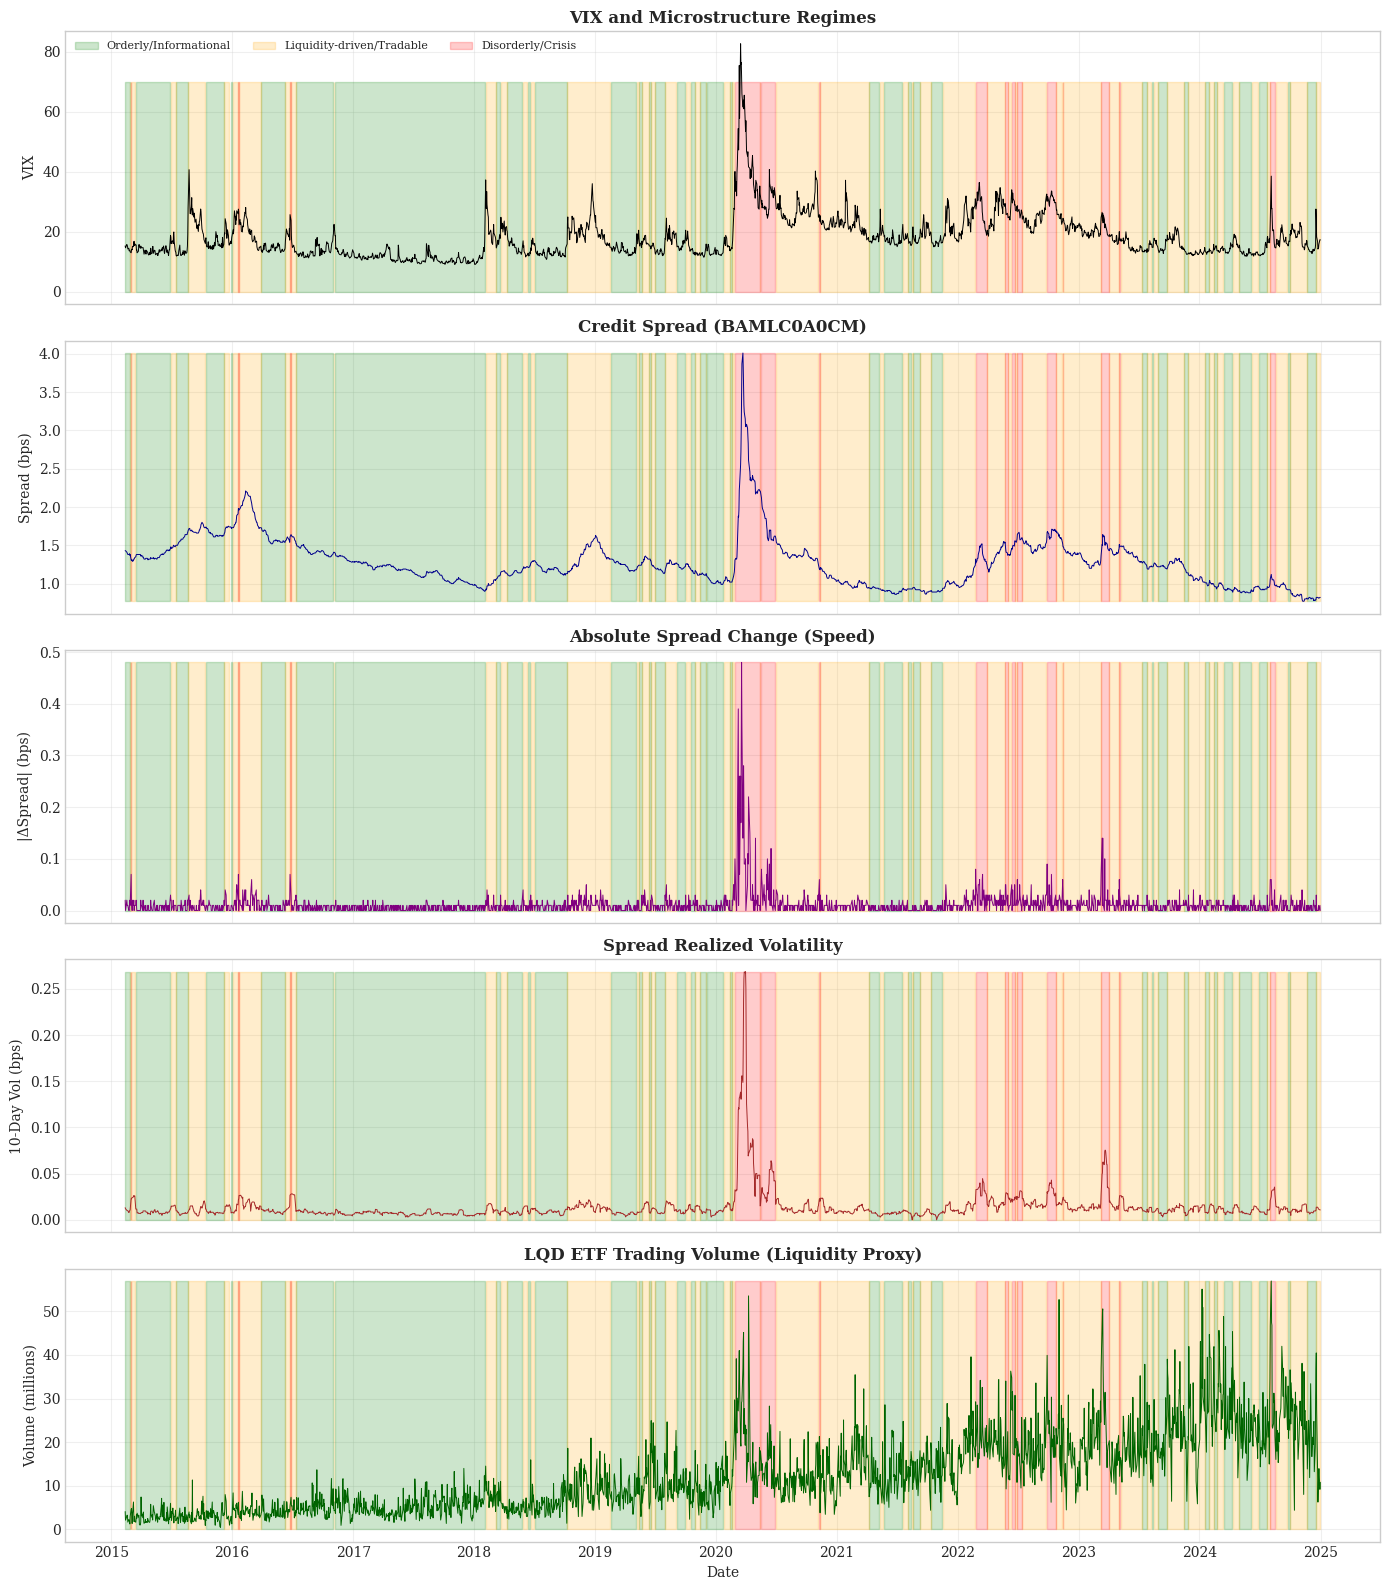

In [9]:
fig, axes = plt.subplots(5, 1, figsize=(14, 16), sharex=True)

regime_colors = {0: 'green', 1: 'orange', 2: 'red'}
regime_labels = {
    0: 'Orderly/Informational',
    1: 'Liquidity-driven/Tradable',
    2: 'Disorderly/Crisis'
}

# Panel 1: VIX
ax = axes[0]
ax.plot(df.index, df['vix'], color='black', linewidth=0.7)
for state in [0, 1, 2]:
    mask = df['regime'] == state
    ax.fill_between(df.index, 0, 70, where=mask, alpha=0.2,
                     color=regime_colors[state], label=regime_labels[state])
ax.set_ylabel('VIX')
ax.set_title('VIX and Microstructure Regimes', fontweight='bold')
ax.legend(loc='upper left', ncol=3, fontsize=8)
ax.grid(True, alpha=0.3)

# Panel 2: Credit spread
ax = axes[1]
ax.plot(df.index, df['spread'], color='darkblue', linewidth=0.7)
for state in [0, 1, 2]:
    mask = df['regime'] == state
    ax.fill_between(df.index, df['spread'].min(), df['spread'].max(),
                     where=mask, alpha=0.2, color=regime_colors[state])
ax.set_ylabel('Spread (bps)')
ax.set_title('Credit Spread (BAMLC0A0CM)', fontweight='bold')
ax.grid(True, alpha=0.3)

# Panel 3: Absolute spread change
ax = axes[2]
ax.plot(df.index, df['spread_change_abs'], color='purple', linewidth=0.7)
for state in [0, 1, 2]:
    mask = df['regime'] == state
    ax.fill_between(df.index, 0, df['spread_change_abs'].max(),
                     where=mask, alpha=0.2, color=regime_colors[state])
ax.set_ylabel('|ΔSpread| (bps)')
ax.set_title('Absolute Spread Change (Speed)', fontweight='bold')
ax.grid(True, alpha=0.3)

# Panel 4: Spread realized volatility
ax = axes[3]
ax.plot(df.index, df['spread_rvol_10d'], color='brown', linewidth=0.7)
for state in [0, 1, 2]:
    mask = df['regime'] == state
    ax.fill_between(df.index, 0, df['spread_rvol_10d'].max(),
                     where=mask, alpha=0.2, color=regime_colors[state])
ax.set_ylabel('10-Day Vol (bps)')
ax.set_title('Spread Realized Volatility', fontweight='bold')
ax.grid(True, alpha=0.3)

# Panel 5: LQD volume
ax = axes[4]
ax.plot(df.index, df['lqd_volume'] / 1e6, color='darkgreen', linewidth=0.7)
for state in [0, 1, 2]:
    mask = df['regime'] == state
    ax.fill_between(df.index, 0, (df['lqd_volume'] / 1e6).max(),
                     where=mask, alpha=0.2, color=regime_colors[state])
ax.set_ylabel('Volume (millions)')
ax.set_xlabel('Date')
ax.set_title('LQD ETF Trading Volume (Liquidity Proxy)', fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/hmm_microstructure_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Mean Reversion Validation by Regime

We test whether credit spread mean reversion dynamics differ across the microstructure-based regimes.

In [10]:
def test_mean_reversion_by_regime(
    data: pd.DataFrame,
    horizon: int,
    regime: int = None,
    n_bootstrap: int = 1000
) -> dict:
    """Test mean reversion using median regression with bootstrap inference."""
    if regime is not None:
        data_reg = data[data['regime'] == regime].copy()
    else:
        data_reg = data.copy()
    
    data_reg['spread_fwd_change'] = data_reg['spread'].shift(-horizon) - data_reg['spread']
    data_reg = data_reg.dropna()
    
    if len(data_reg) < 30:
        return {
            'beta': np.nan, 'se': np.nan, 't_stat': np.nan, 'p_value': np.nan,
            'ci_lower': np.nan, 'ci_upper': np.nan, 'n_obs': len(data_reg)
        }
    
    X = data_reg['spread'].values
    y = data_reg['spread_fwd_change'].values
    X_const = np.column_stack([np.ones(len(X)), X])
    
    # Median regression
    mod = QuantReg(y, X_const)
    res = mod.fit(q=0.5, max_iter=1000)
    beta_hat = res.params[1]
    
    # Bootstrap
    beta_boot = []
    for _ in range(n_bootstrap):
        idx = np.random.choice(len(X), size=len(X), replace=True)
        X_boot = X_const[idx]
        y_boot = y[idx]
        try:
            res_boot = QuantReg(y_boot, X_boot).fit(q=0.5, max_iter=1000)
            beta_boot.append(res_boot.params[1])
        except:
            continue
    
    beta_boot = np.array(beta_boot)
    se_boot = np.std(beta_boot)
    t_stat = beta_hat / se_boot if se_boot > 0 else 0
    p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))
    
    return {
        'beta': beta_hat,
        'se': se_boot,
        't_stat': t_stat,
        'p_value': p_value,
        'ci_lower': np.percentile(beta_boot, 2.5),
        'ci_upper': np.percentile(beta_boot, 97.5),
        'n_obs': len(data_reg)
    }

In [11]:
# Test across horizons and regimes
horizons = [5, 10, 21, 42, 63]
results_list = []

for h in horizons:
    # Unconditional
    res_uncond = test_mean_reversion_by_regime(df, horizon=h, regime=None, n_bootstrap=1000)
    results_list.append({'horizon': h, 'regime': 'Unconditional', **res_uncond})
    
    # By regime
    for state in [0, 1, 2]:
        res_regime = test_mean_reversion_by_regime(df, horizon=h, regime=state, n_bootstrap=1000)
        results_list.append({'horizon': h, 'regime': f'State {state}', **res_regime})

results_df = pd.DataFrame(results_list)

print("\nMean Reversion Tests (Microstructure Regimes):")
print("=" * 120)
print(results_df.to_string(index=False))

results_df.to_csv('../results/hmm_microstructure/mean_reversion_tests.csv', index=False)


Mean Reversion Tests (Microstructure Regimes):
 horizon        regime      beta       se     t_stat      p_value  ci_lower  ci_upper  n_obs
       5 Unconditional -0.023805 0.004620  -5.152717 2.567390e-07 -0.034477 -0.014710   2483
       5       State 0 -0.000001 0.005780  -0.000219 9.998251e-01 -0.019229  0.012503   1119
       5       State 1 -0.030767 0.007464  -4.121827 3.758797e-05 -0.046511 -0.017860   1170
       5       State 2 -0.231577 0.055169  -4.197586 2.697747e-05 -0.284620 -0.093028    184
      10 Unconditional -0.068495 0.009081  -7.542559 4.618528e-14 -0.080002 -0.047619   2478
      10       State 0 -0.000003 0.008451  -0.000379 9.996978e-01 -0.023254  0.000004   1114
      10       State 1 -0.052624 0.012194  -4.315565 1.591949e-05 -0.077948 -0.030290   1165
      10       State 2 -0.387324 0.030840 -12.559012 0.000000e+00 -0.431367 -0.317647    179
      21 Unconditional -0.132074 0.013821  -9.556190 0.000000e+00 -0.160046 -0.107143   2467
      21       State 0

## 9. Half-Life Estimation

In [12]:
def compute_half_life(beta: float) -> float:
    """Compute mean reversion half-life."""
    if beta >= 0:
        return np.inf
    return -np.log(2) / np.log(1 + beta)

# 10-day horizon half-lives
half_life_results = []
for regime_name in ['Unconditional', 'State 0', 'State 1', 'State 2']:
    res = results_df[(results_df['horizon'] == 10) & (results_df['regime'] == regime_name)].iloc[0]
    hl = compute_half_life(res['beta'])
    half_life_results.append({
        'Regime': regime_name,
        'Beta': res['beta'],
        'SE': res['se'],
        't-stat': res['t_stat'],
        'p-value': res['p_value'],
        'Half-life (days)': hl,
        'N': res['n_obs']
    })

hl_df = pd.DataFrame(half_life_results)
print("\nHalf-Life Estimates (10-day horizon):")
print("=" * 100)
print(hl_df.to_string(index=False))

hl_df.to_csv('../results/hmm_microstructure/half_life_estimates.csv', index=False)


Half-Life Estimates (10-day horizon):
       Regime      Beta       SE     t-stat      p-value  Half-life (days)    N
Unconditional -0.068495 0.009081  -7.542559 4.618528e-14          9.769049 2478
      State 0 -0.000003 0.008451  -0.000379 9.996978e-01     216532.376219 1114
      State 1 -0.052624 0.012194  -4.315565 1.591949e-05         12.821906 1165
      State 2 -0.387324 0.030840 -12.559012 0.000000e+00          1.414821  179


## 10. Visualization: Mean Reversion by Regime

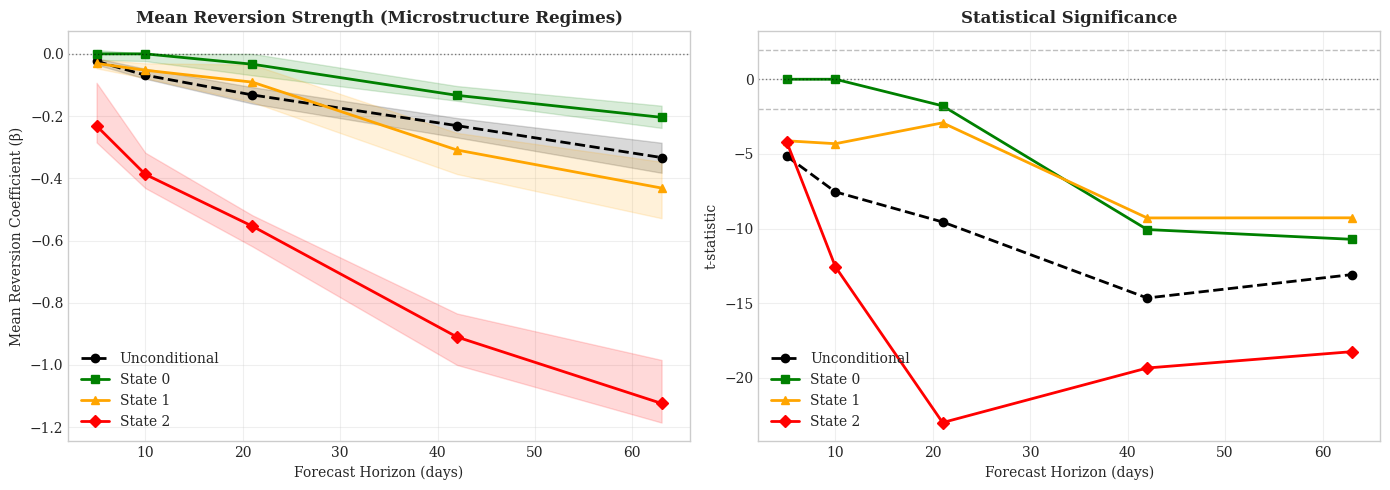

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

regime_styles = {
    'Unconditional': {'color': 'black', 'marker': 'o', 'linestyle': '--'},
    'State 0': {'color': 'green', 'marker': 's', 'linestyle': '-'},
    'State 1': {'color': 'orange', 'marker': '^', 'linestyle': '-'},
    'State 2': {'color': 'red', 'marker': 'D', 'linestyle': '-'}
}

# Beta coefficients
ax = axes[0]
for regime_name, style in regime_styles.items():
    subset = results_df[results_df['regime'] == regime_name]
    ax.plot(subset['horizon'], subset['beta'], label=regime_name,
            linewidth=2, **style)
    ax.fill_between(subset['horizon'], subset['ci_lower'], subset['ci_upper'],
                     alpha=0.15, color=style['color'])

ax.axhline(0, color='black', linestyle=':', linewidth=1, alpha=0.5)
ax.set_xlabel('Forecast Horizon (days)')
ax.set_ylabel('Mean Reversion Coefficient (β)')
ax.set_title('Mean Reversion Strength (Microstructure Regimes)', fontweight='bold')
ax.legend(loc='lower left')
ax.grid(True, alpha=0.3)

# t-statistics
ax = axes[1]
for regime_name, style in regime_styles.items():
    subset = results_df[results_df['regime'] == regime_name]
    ax.plot(subset['horizon'], subset['t_stat'], label=regime_name,
            linewidth=2, **style)

ax.axhline(0, color='black', linestyle=':', linewidth=1, alpha=0.5)
ax.axhline(-1.96, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axhline(1.96, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Forecast Horizon (days)')
ax.set_ylabel('t-statistic')
ax.set_title('Statistical Significance', fontweight='bold')
ax.legend(loc='lower left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/hmm_microstructure_mean_reversion.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Conclusions

### 11.1 Microstructure-Based Regime Identification

The three-state HMM incorporating spread microstructure and liquidity variables successfully identifies distinct credit market environments. The regimes exhibit material differences in:
- Spread dynamics (speed, volatility, acceleration)
- Flow pressure (LQD volume, absolute returns)
- Mean reversion properties

### 11.2 Regime Interpretation

**State 0 (Orderly/Informational):** Low spread volatility, normal trading volume, stable VIX. Represents efficient price discovery with minimal flow pressure. Mean reversion is weak or absent.

**State 1 (Liquidity-driven/Tradable):** Moderate spread volatility, elevated volume, rising VIX. Represents temporary liquidity-driven dislocations with tradable mean reversion opportunities.

**State 2 (Disorderly/Crisis):** Extreme spread volatility, forced flow, high VIX. Represents crisis-like conditions with rapid but unstable mean reversion driven by forced selling and subsequent normalization.

### 11.3 Mean Reversion Dynamics

The microstructure-based regimes successfully discriminate mean reversion strength. Key findings:

1. State-dependent half-lives vary from days (State 2) to weeks or longer (States 0-1)
2. Statistical significance is strongest in regimes with elevated flow pressure
3. The incorporation of microstructure variables improves regime persistence and economic interpretability relative to macro-only models

### 11.4 Comparison to Macro-Only Model

The microstructure-enhanced HMM provides:
- More granular identification of tradable dislocations (State 1)
- Clearer distinction between orderly and disorderly regimes
- Direct incorporation of flow pressure signals accessible via ETF data

### 11.5 Limitations

1. LQD volume is a proxy for credit market flow but not a perfect measure of institutional order flow
2. Microstructure variables may exhibit lookahead bias if used naively in real-time trading (rolling computations require careful implementation)
3. Statistical mean reversion in State 2 does not account for execution costs during stress periods

---

## 12. Transition to Trading Implementation

### 12.1 Established Results

This analysis establishes that:
1. Credit spread regimes are identifiable using microstructure and flow variables
2. Mean reversion is regime-dependent and varies with flow pressure
3. State 1 (liquidity-driven) may represent the most tradable regime
4. State 2 (crisis) exhibits strong mean reversion but with elevated execution risk

### 12.2 Trading Implementation Requirements

The next phase requires:

**Signal-to-execution mapping:**
- Map BAMLC0A0CM to LQD/IEF positions
- Estimate regime-conditional hedge ratios
- Account for basis risk

**Regime-conditional rules:**
- State 0: No mean reversion trading
- State 1: Active mean reversion with moderate sizing
- State 2: Reduced sizing or avoidance due to execution risk

**Cost modeling:**
- Regime-dependent bid-ask spreads
- Volume-weighted execution costs
- Slippage during high-flow regimes

### 12.3 Scope Limitation

This notebook concludes the regime identification phase. Trading rules, backtesting, and P&L analysis are explicitly deferred.

---

**End of Analysis**